<a href="https://colab.research.google.com/github/evakaldy/collaborative-quotes/blob/main/LSTM_fit_c02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
import statsmodels.api as sm

# Load the dataset
data = sm.datasets.co2.load_pandas().data
data

,co2
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2
2001-12-22,371.3


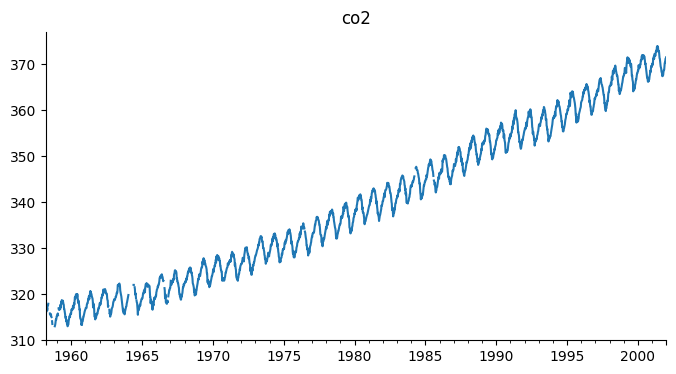

In [ ]:
from matplotlib import pyplot as plt
data['co2'].plot(kind='line', figsize=(8, 4), title='co2')
plt.gca().spines[['top', 'right']].set_visible(False)

<ipython-input-202-a0e67000c207>:4: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



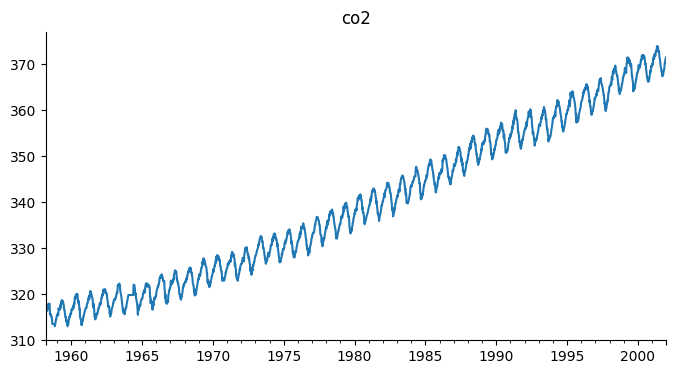

In [ ]:
# FILL NaN  - test

d = data.copy()
d.fillna(method='ffill', inplace=True)  # Handling missing values - by the same number as previous
# print(d)
d['co2'].plot(kind='line', figsize=(8, 4), title='co2')
plt.gca().spines[['top', 'right']].set_visible(False)

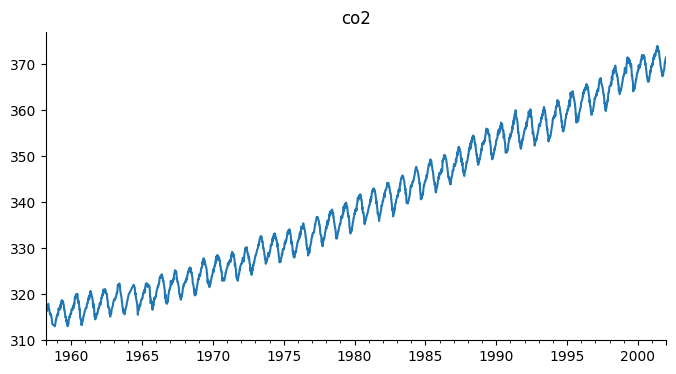

In [ ]:
# FILL NaN  - linear

e = data.copy()
e.interpolate(method='linear', inplace=True)  # Handling missing values - by the same number as previous
data.interpolate(method='linear', inplace=True)  # Handling missing values - by the same number as previous
# print(d)
data['co2'].plot(kind='line', figsize=(8, 4), title='co2')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# The pd.date_range function generates a sequence of dates starting from March 1, 1958, spaced one week apart, and all falling on Saturdays.
data['date'] = pd.date_range(start='1958-03-29', periods=len(data), freq='W-SAT')
data

,co2,date
1958-03-29,316.1,1958-03-29
1958-04-05,317.3,1958-04-05
1958-04-12,317.6,1958-04-12
1958-04-19,317.5,1958-04-19
1958-04-26,316.4,1958-04-26
...,...,...
2001-12-01,370.3,2001-12-01
2001-12-08,370.8,2001-12-08
2001-12-15,371.2,2001-12-15
2001-12-22,371.3,2001-12-22


In [ ]:
data.set_index('date', inplace=True)
data

,co2
date,
1958-03-29,316.1
1958-04-05,317.3
1958-04-12,317.6
1958-04-19,317.5
1958-04-26,316.4
...,...
2001-12-01,370.3
2001-12-08,370.8
2001-12-15,371.2


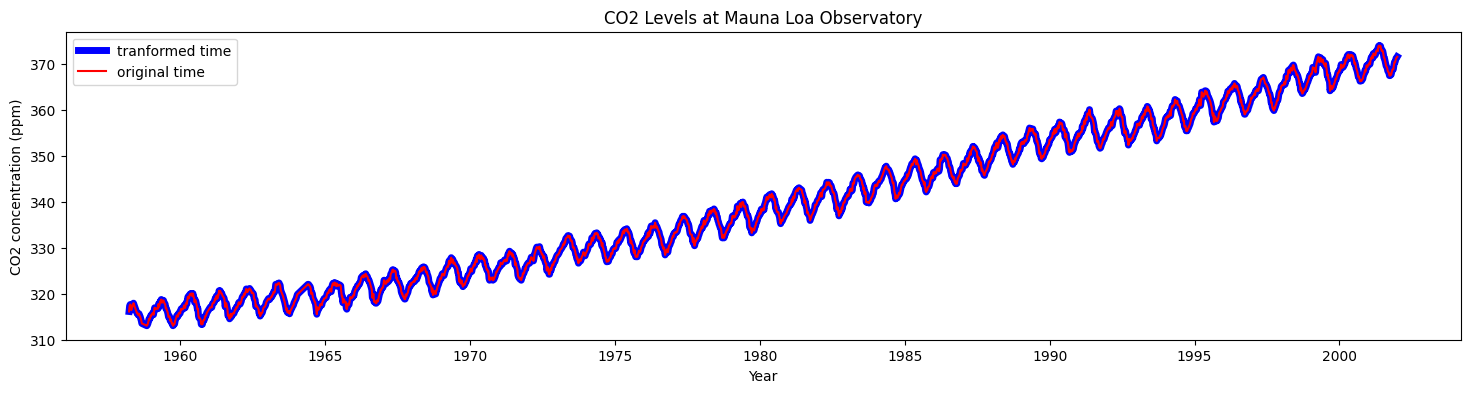

In [ ]:
# Visualize the dataset
plt.figure(figsize=(18, 4))
plt.plot(data['co2'],color='blue',linewidth=5)
plt.plot(e['co2'], color='red')
plt.legend(['tranformed time','original time'])
plt.title('CO2 Levels at Mauna Loa Observatory')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('Year')
plt.show()

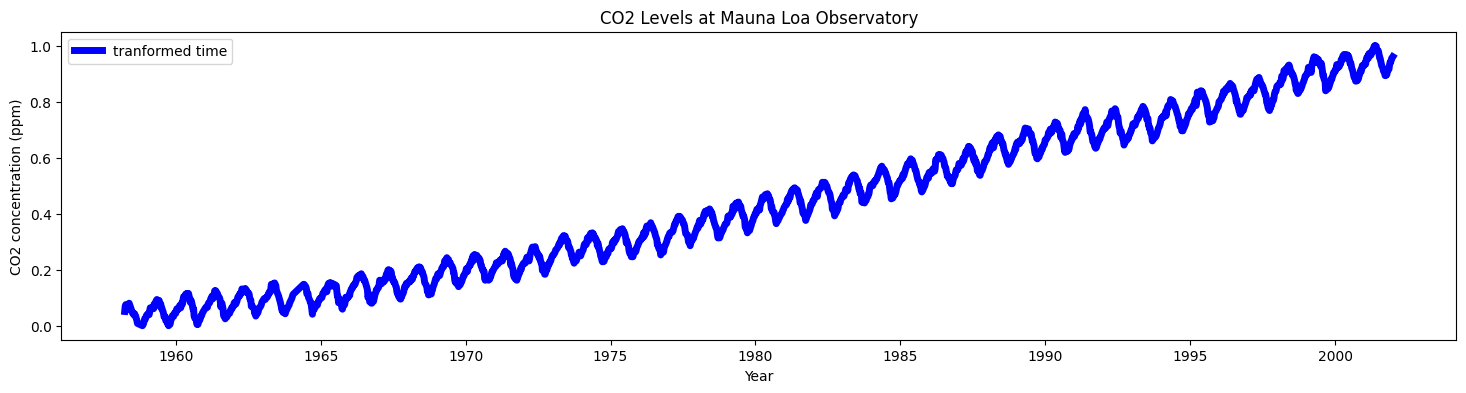

In [ ]:
# Preprocess the data: Normalization of the CO2 data to 0-1
# there is an inversetransform feature of the scaler :) to be used later
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['co2'].values.reshape(-1, 1))
scaled_data

# Visualize the dataset
plt.figure(figsize=(18, 4))
plt.plot( data.index, scaled_data,label='Values', color='blue',linewidth=5)
# plt.plot(e['co2'], color='red')
plt.legend(['tranformed time','original time'])
plt.title('CO2 Levels at Mauna Loa Observatory')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('Year')
plt.show()

In [ ]:
# Define the create_dataset function for creating test data set (on which is it going to be trained )
def create_dataset(dataset, look_back=3):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10  # Use last week's CO2 levels to predict the current week
X, y = create_dataset(scaled_data, look_back)
X, y

(array([[0.05090312, 0.07060755, 0.07553366, ..., 0.07389163, 0.08045977,
         0.07471264],
        [0.07060755, 0.07553366, 0.07389163, ..., 0.08045977, 0.07471264,
         0.06896552],
        [0.07553366, 0.07389163, 0.05582923, ..., 0.07471264, 0.06896552,
         0.06321839],
        ...,
        [0.89326765, 0.8998358 , 0.89655172, ..., 0.93103448, 0.9408867 ,
         0.9408867 ],
        [0.8998358 , 0.89655172, 0.9047619 , ..., 0.9408867 , 0.9408867 ,
         0.94909688],
        [0.89655172, 0.9047619 , 0.91461412, ..., 0.9408867 , 0.94909688,
         0.95566502]]),
 array([0.06896552, 0.06321839, 0.05747126, ..., 0.94909688, 0.95566502,
        0.95730706]))

In [ ]:
 np.array(data.index)

array(['1958-03-29T00:00:00.000000000', '1958-04-05T00:00:00.000000000',
       '1958-04-12T00:00:00.000000000', ...,
       '2001-12-15T00:00:00.000000000', '2001-12-22T00:00:00.000000000',
       '2001-12-29T00:00:00.000000000'], dtype='datetime64[ns]')

In [ ]:
# Split the data into training and testing datasets
# 67% to train the data
train_size = int(len(X) * 0.67)
test_size = len(X) - train_size
train_X, train_y = X[:train_size], y[:train_size]
test_X, test_y = X[train_size:], y[train_size:]
print(train_X[:10])
train_X.shape

# Split the data into training and testing datasets
# random selection of points

from sklearn.model_selection import train_test_split


# Split the arrays into training and testing sets
X_train, X_test, y_train, y_test, train_idx, test_idx = train_test_split(X, y, range(len(y)), test_size=0.2, random_state=42)
X_train.shape
# print("X_train:", X_train)
# print("X_test:", X_test)
# print("y_train:", y_train)
# print("y_test:", y_test)


# Reshape input to be [samples, time steps, features]
# test group by the example -
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))


X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# lets try different trainingv and testing data set
train_X = X_train
test_X = X_test
train_y = y_train
test_y = y_test
train_size = len(train_y)

[[0.05090312 0.07060755 0.07553366 0.07389163 0.05582923 0.06403941
  0.06896552 0.07389163 0.08045977 0.07471264]
 [0.07060755 0.07553366 0.07389163 0.05582923 0.06403941 0.06896552
  0.07389163 0.08045977 0.07471264 0.06896552]
 [0.07553366 0.07389163 0.05582923 0.06403941 0.06896552 0.07389163
  0.08045977 0.07471264 0.06896552 0.06321839]
 [0.07389163 0.05582923 0.06403941 0.06896552 0.07389163 0.08045977
  0.07471264 0.06896552 0.06321839 0.05747126]
 [0.05582923 0.06403941 0.06896552 0.07389163 0.08045977 0.07471264
  0.06896552 0.06321839 0.05747126 0.05172414]
 [0.06403941 0.06896552 0.07389163 0.08045977 0.07471264 0.06896552
  0.06321839 0.05747126 0.05172414 0.04597701]
 [0.06896552 0.07389163 0.08045977 0.07471264 0.06896552 0.06321839
  0.05747126 0.05172414 0.04597701 0.04597701]
 [0.07389163 0.08045977 0.07471264 0.06896552 0.06321839 0.05747126
  0.05172414 0.04597701 0.04597701 0.03940887]
 [0.08045977 0.07471264 0.06896552 0.06321839 0.05747126 0.05172414
  0.04597701

In [ ]:

# Define the LSTM model
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Fit the model
model.fit(train_X, train_y, epochs=10, batch_size=1, verbose=2)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



1818/1818 - 4s - 2ms/step - loss: 0.0079
Epoch 2/10
1818/1818 - 3s - 1ms/step - loss: 4.9019e-04
Epoch 3/10
1818/1818 - 5s - 3ms/step - loss: 3.9546e-04
Epoch 4/10
1818/1818 - 5s - 3ms/step - loss: 3.0207e-04
Epoch 5/10
1818/1818 - 3s - 1ms/step - loss: 2.1645e-04
Epoch 6/10
1818/1818 - 4s - 2ms/step - loss: 1.7286e-04
Epoch 7/10
1818/1818 - 4s - 2ms/step - loss: 1.5838e-04
Epoch 8/10
1818/1818 - 3s - 1ms/step - loss: 1.5308e-04
Epoch 9/10
1818/1818 - 3s - 1ms/step - loss: 1.3637e-04
Epoch 10/10
1818/1818 - 5s - 3ms/step - loss: 1.2720e-04


In [ ]:
# Make predictions
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)
print('-------test_predict--------')
print(test_predict[:5])
print('-------test_X--------')
print(test_X[:5])

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
-------test_predict--------
[[0.88974226]
 [0.43421176]
 [0.25412664]
 [0.15903986]
 [0.24294621]]
-------test_X--------
[[[0.95730706 0.94909688 0.93596059 0.93924466 0.93103448 0.91954023
   0.91461412 0.90804598 0.89819376 0.88834154]]

 [[0.50410509 0.50246305 0.48604269 0.49261084 0.47126437 0.47783251
   0.4729064  0.44170772 0.44170772 0.44006568]]

 [[0.23481117 0.22824302 0.23481117 0.23481117 0.22988506 0.23809524
   0.24137931 0.24466338 0.24630542 0.25944171]]

 [[0.13136289 0.13300493 0.13464696 0.14285714 0.14121511 0.14449918
   0.14942529 0.14942529 0.15599343 0.16091954]]

 [[0.24302135 0.2545156  0.24466338 0.23809524 0.24630542 0.25123153
   0.24466338 0.23809524 0.24302135 0.24137931]]]


In [ ]:
# Inverse transform the predictions
# the CO2 data were intially coverted to 0-1, now turned back into original units
train_predict = scaler.inverse_transform(train_predict)
train_y = scaler.inverse_transform([train_y])
test_predict = scaler.inverse_transform(test_predict)
test_y = scaler.inverse_transform([test_y])

In [ ]:
# Calculate root mean squared error
trainScore = np.sqrt(np.mean((train_predict - train_y) ** 2))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(np.mean((test_predict - test_y) ** 2))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 24.32 RMSE
Test Score: 23.69 RMSE


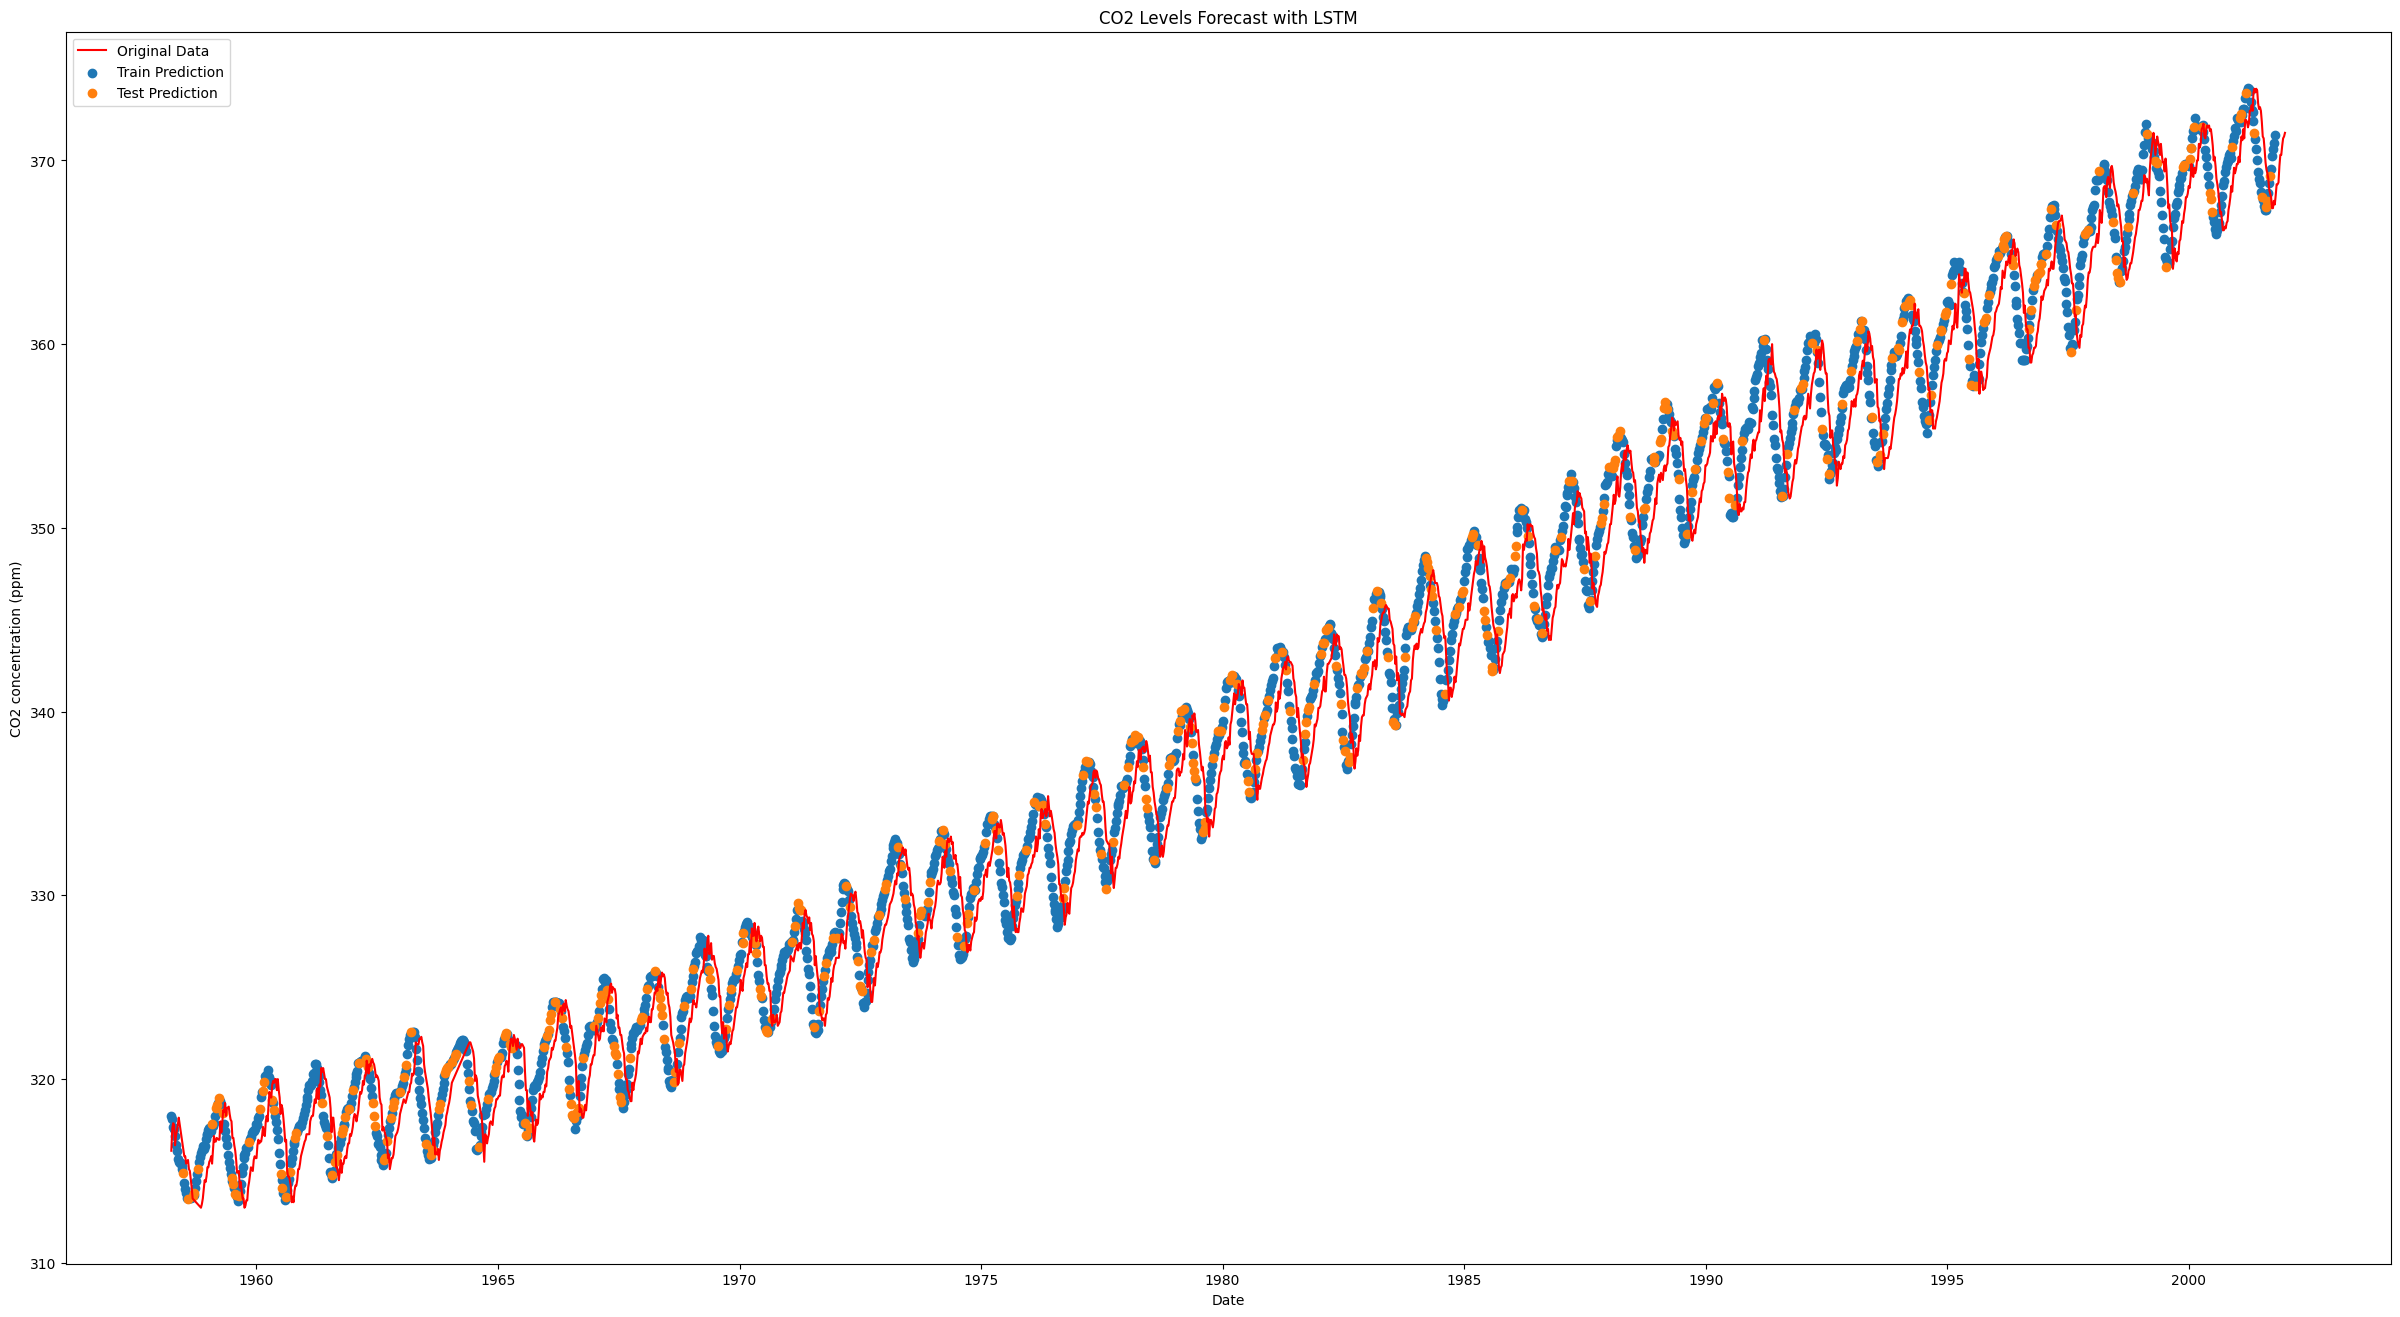

In [ ]:
# Extract dates for the predictions
dates = data.index
train_idx, test_idx
plt.figure(figsize=(30, 16))

# Plot original dataset
plt.plot(dates, scaler.inverse_transform(scaled_data), label='Original Data', color='red')

# Plot training predictions
# Here we exclude the first `look_back` data points because the first prediction requires `look_back` points
# train_dates = dates[look_back:train_size + look_back]
train_dates = dates[train_idx]
plt.scatter(train_dates, train_predict, label='Train Prediction')

# Plot test predictions
# Adjusted test_dates to match the length of test_predict
# test_dates = dates[train_size + look_back:train_size + look_back + len(test_predict)]
test_dates = dates[test_idx]
plt.scatter(test_dates, test_predict, label='Test Prediction')

plt.title('CO2 Levels Forecast with LSTM')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [ ]:
import plotly.express as px

num_future = 50  # Number of future predictions
last_data = scaled_data[-look_back:] # to be used for future prediction
print(last_data[:5])

[[0.91461412]
 [0.91461412]
 [0.91625616]
 [0.93103448]
 [0.9408867 ]]


In [ ]:


future_predictions = []

# Generate future predictions
for _ in range(num_future):
    x_input = last_data.reshape((1, 1, look_back))
    yhat = model.predict(x_input)
    future_predictions.append(yhat[0, 0])
    last_data = np.append(last_data, yhat)[1:]

# Inverse transform predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
print(future_predictions)

# Create a DataFrame for future predictions
future_dates = pd.date_range(start=data.index[-1], periods=num_future + 1, freq='W-SAT')[1:]
df_future = pd.DataFrame({"date": future_dates, "co2": future_predictions.flatten()})
df_future["Type"] = "Prediction"

# Add a column to the historical data
data["Type"] = "Historical"

# Combine historical and future data
df_combined = pd.concat([data.reset_index(), df_future]).reset_index(drop=True)
print(df_combined)

# Plot using Plotly
fig = px.line(
    df_combined,
    x="date",
    y="co2",
    color="Type",
    title="CO2 Levels with Forecast",
    color_discrete_map={"Historical": "blue", "Prediction": "red"},
)
fig.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

In [ ]:
# Plot the combined data
fig = px.line(df_combined, x=df_combined.index, y='co2', title="CO2 Levels with Forecast")
fig.show()


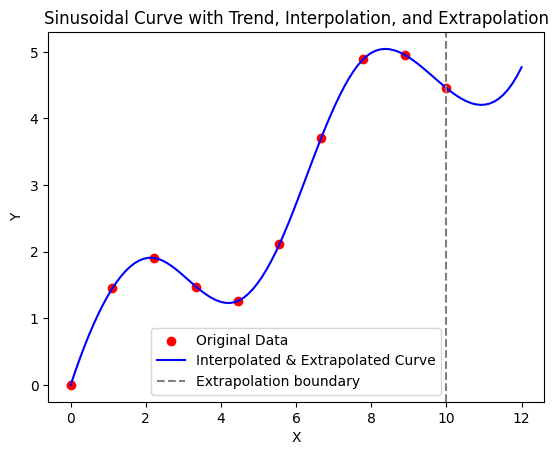

In [ ]:
from scipy import interpolate

# Step 1: Generate some example data (sinusoidal with a linear trend)
x = np.linspace(0, 10, 10)  # Example data points
y = np.sin(x) + 0.5 * x  # Sinusoidal curve with added linear trend

# Plot the original data
plt.scatter(x, y, color='red', label="Original Data")

# Step 2: Interpolate the data (using cubic spline interpolation)
f = interpolate.CubicSpline(x, y)

# Create a smoother set of x values
x_smooth = np.linspace(0, 12, 100)  # Smooth points for interpolation and extrapolation
y_smooth = f(x_smooth)

# Plot the interpolated curve
plt.plot(x_smooth, y_smooth, label="Interpolated & Extrapolated Curve", color='blue')

# Step 3: Extrapolation happens here by evaluating `f(x_smooth)` beyond the original range
plt.axvline(x=10, color='gray', linestyle='--', label='Extrapolation boundary')

# Display the plot
plt.legend()
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Sinusoidal Curve with Trend, Interpolation, and Extrapolation')
plt.show()

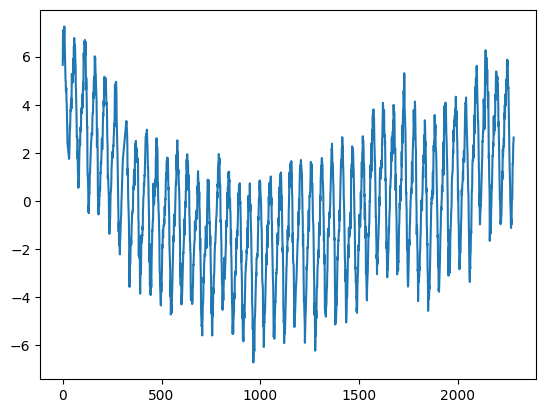

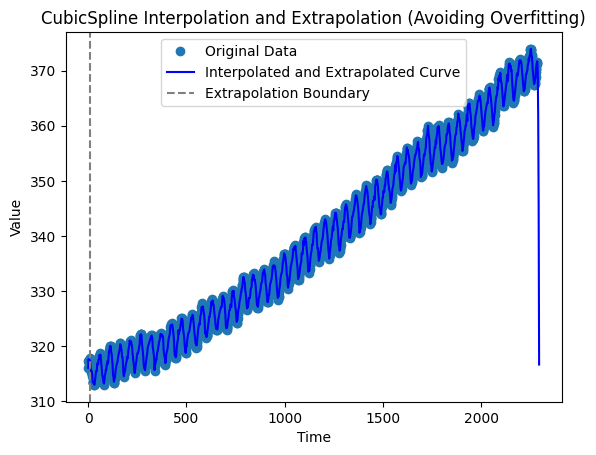

In [ ]:
predic_weeks = 10
x = range(len(data))
y = data['co2']
# Fit a linear trend (remove linear component)
trend = np.polyfit(x, y, 1)  # Linear fit (1st degree polynomial)
y_detrended = y - (trend[0] * x + trend[1])  # Detrended data

plt.plot(x, y_detrended)
plt.show()
# Interpolate the seasonal component (sine-like part) using cubic spline
spline = interpolate.CubicSpline(x, y_detrended, bc_type='natural')  # 'natural' for smoothness

# Create a smoother range for extrapolation
x_smooth = np.linspace(0, len(x) + predic_weeks, 1000)
y_smooth = spline(x_smooth) + (trend[0] * x_smooth + trend[1])  # Add back the trend

# Plot the results
plt.plot(x, y, 'o', label="Original Data")  # Original data
plt.plot(x_smooth, y_smooth, label="Interpolated and Extrapolated Curve", color='blue')
plt.axvline(x=10, color='gray', linestyle='--', label='Extrapolation Boundary')
plt.legend()
plt.title('CubicSpline Interpolation and Extrapolation (Avoiding Overfitting)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

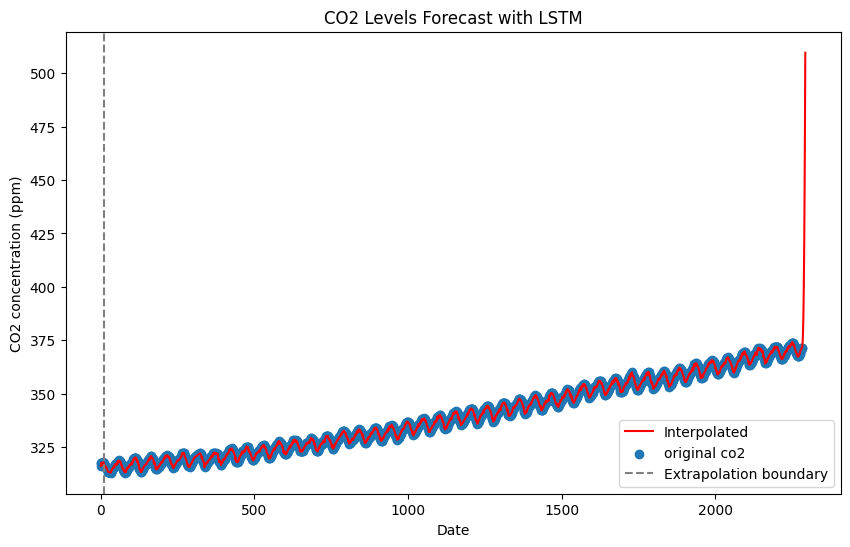

In [ ]:
predic_weeks = 10
x = range(len(data))
y = data['co2']
# Fit a linear trend (remove linear component)
trend = np.polyfit(x, y, 1)  # Linear fit (1st degree polynomial)
y_detrended = y - (trend[0] * x + trend[1])  # Detrended data


# Interpolate the seasonal component (sine-like part) using cubic spline
spline = interpolate.CubicSpline(x, y_detrended, bc_type='natural')  # 'natural' for smoothness

# Create a smoother range for extrapolation
x_smooth = np.linspace(0, 15, 100)
y_smooth = spline(x_smooth) + (trend[0] * x_smooth + trend[1])  # Add back the trend

# Plot the results
plt.plot(x, y, 'o', label="Original Data")  # Original data
plt.plot(x_smooth, y_smooth, label="Interpolated and Extrapolated Curve", color='blue')
plt.axvline(x=10, color='gray', linestyle='--', label='Extrapolation Boundary')
plt.legend()
plt.title('CubicSpline Interpolation and Extrapolation (Avoiding Overfitting)')
plt.xlabel('Time')
plt.ylabel('Value')
plt.show()

from scipy import interpolate
f = interpolate.CubicSpline(range(len(data)),data['co2'], extrapolate=True)
# print(f)
x_i = np.array(range(3*len(data) + 3*predic_weeks))/3

y_i = f(x_i)



plt.figure(figsize=(10, 6))
plt.plot(x_i, y_i, label='Interpolated',color='red')
plt.scatter(range(len(data)), data['co2'], label='original co2')


# Step 3: Extrapolation happens here by evaluating `f(x_smooth)` beyond the original range
plt.axvline(x=10, color='gray', linestyle='--', label='Extrapolation boundary')
plt.title('CO2 Levels Forecast with LSTM')
plt.ylabel('CO2 concentration (ppm)')
plt.xlabel('Date')
plt.legend()
plt.show()